<a href="https://colab.research.google.com/github/noeyhey/HUFS_MachineLearning/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project#1. Adult Income 데이터를 활용한 전처리 및 분류 모델 비교**

#### 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

Loading original data...

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

filepath = '/content/gdrive/MyDrive/adult.csv'
df = pd.read_csv(filepath)
df.replace('?', np.nan, inplace=True)
print(f"Original data shape: {df.shape}")
print(f"결측치가 포함된 행 수: {df.isnull().any(axis=1).sum()}")

Mounted at /content/gdrive
Original data shape: (32561, 15)
결측치가 포함된 행 수: 2399


In [ ]:
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### 4.1 데이터 분할

Encoding target variable using LabelEncoder

In [ ]:
df['income'] = df['income'].str.strip()  # remove trailing space or dot
le = LabelEncoder()
df['income'] = le.fit_transform(df['income'])  # '<=50K' → 0, '>50K' → 1

print("Target classes:", list(le.classes_))
print("\nEncoded class distribution:")
print(df['income'].value_counts())

Target classes: ['<=50K', '>50K']

Encoded class distribution:
income
0    24720
1     7841
Name: count, dtype: int64


Splitting into train and test (stratify by income)

In [ ]:
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train class distribution:
income
0    0.759175
1    0.240825
Name: proportion, dtype: float64

Test class distribution:
income
0    0.759251
1    0.240749
Name: proportion, dtype: float64


#### 4.2 결측치 처리

(1) Dropping missing values (결측치 제거 방식)

In [ ]:
# DROP 방식 전처리
train_df = pd.concat([X_train, y_train], axis=1).dropna()
test_df = pd.concat([X_test, y_test], axis=1).dropna()
print(f"After drop - Train: {train_df.shape}, Test: {test_df.shape}")

X_train_drop = train_df.drop('income', axis=1)
y_train_drop = train_df['income']
X_test_drop = test_df.drop('income', axis=1)
y_test_drop = test_df['income']

print(f"After drop - Train: {X_train_drop.shape}, Test: {X_test_drop.shape}")

After drop - Train: (24148, 15), Test: (6014, 15)
After drop - Train: (24148, 14), Test: (6014, 14)


(2) 결측치 대체 방식

• 숫자형 변수는 평균(mean)으로, 범주형 변수는 최빈값(mode)으로 결측치를
대체합니다.

• drop과 impute 방식에서 최종 데이터 크기 차이를 비교하고 간단히 분석
합니다.

✔ fit() vs transform() vs fit_transform() 구분 ✔

* fit():	훈련 데이터를 기반으로 평균, 최빈값 등 필요한 통계값을 계산

* transform():	이미 계산된 값(평균, 최빈값 등)을 사용해 데이터를 변환

* fit_transform()	fit() + transform(): 한 번에 실행



---

❗ 테스트 데이터에는 transform()만 사용
* 훈련 데이터에서 결측치를 평균값 25로 대체 가정
* 테스트 데이터에서 fit_transform을 다시하면 훈련이 다시 되고 테스트 데이터만의 평균을 다시 계산 후 적용하게 됨

→ 즉,  transform()만 하면 훈련 데이터에서 계산한 25로 그대로 대체
* 일관성 유지 가능함
* 데이터 누수(data leakage) 없이, 실제 상황과 유사한 테스트가 가능

In [ ]:
# IMPUTE 방식 전처리

# 숫자형, 범주형 변수 구분
X_train_cat = X_train.select_dtypes(include='object') # category
X_train_num = X_train.select_dtypes(include=['int64', 'float64']) # numeric

## exclude='object'

# 숫자형 → 평균(mean), 범주형 → 최빈값(mode)으로 Imputer 설정
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

# 훈련 데이터, fit_transform
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=X_train_cat.columns)
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns)

# 숫자형과 범주형 데이터 합치기
X_train_imp = pd.concat([X_train_cat_imp, X_train_num_imp], axis=1)

In [ ]:
# 숫자형, 범주형 변수 구분
X_test_cat = X_test.select_dtypes(include='object')
X_test_num = X_test.select_dtypes(include=['int64', 'float64'])

# 테스트 데이터에는 transform만 적용
X_test_cat_imp = pd.DataFrame(cat_imputer.transform(X_test_cat), columns=X_test_cat.columns)
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns)

# 숫자형과 범주형 데이터 합치기
X_test_imp = pd.concat([X_test_cat_imp, X_test_num_imp], axis=1)

# impute 라벨은 drop하지 않은 원본 사용해야 해서 따로 처리
y_train_imp = y_train.reset_index(drop=True)
y_test_imp = y_test.reset_index(drop=True)

In [ ]:
print(f"After impute - Train: {X_train_imp.shape}, Test: {X_test_imp.shape}")

drop_train_size = X_train_drop.shape[0]
impute_train_size = X_train_imp.shape[0]
drop_test_size = X_test_drop.shape[0]
impute_test_size = X_test_imp.shape[0]

print(f"Train 데이터에서 drop 방식은 전체 중 {(1 - drop_train_size / impute_train_size) * 100:.2f}% 의 데이터가 손실됨.")
print(f"Test 데이터에서 drop 방식은 전체 중 {(1 - drop_test_size / impute_test_size) * 100:.2f}% 의 데이터가 손실됨.")

After impute - Train: (26048, 14), Test: (6513, 14)
Train 데이터에서 drop 방식은 전체 중 7.29% 의 데이터가 손실됨.
Test 데이터에서 drop 방식은 전체 중 7.66% 의 데이터가 손실됨.




```
imputed_cat_data = pd.DataFrame(cat_imputer.fit_transform(X_train_cat))
```
위 코드에서 인코딩시 문제 발생,

> cat_imputer.fit_transform(X_train_cat)은 결과를 NumPy 배열로 반환

→ NumPy 배열에는 열 이름(columns)과 데이터 타입(dtype)이 없음

즉, 처음만든 `DataFrame`은 열 이름이 `0, 1, 2...`으로 자동 지정되고 `dtype`도 `object`가 아닐 수 있음.

\**'`dtype`도 `object`가 아닐 수 있음'은 열 이름을 따로 지정해주지 않으면 `0,1`처럼 숫자로 지정되기 때문에 데이터 타입은 object일 수도 있고, 숫자형이면 float64나 int64로 바뀜


---


🛠️ 그래서 무슨 일이 발생하느냐?
```
df_new.select_dtypes(include='object')
```
위 코드가 정상적으로 작동하지 못함.

이게 정상적으로 동작하려면 문자열 타입이면서 열 이름도 정확히 있어야 작동함.

하지만 Imputer 후 만든 DataFrame에서 열 이름을 지정 안 하면:
* select_dtypes()가 범주형 열을 못 찾음
* 나중에 OneHotEncoder가 범주형 열을 찾지 못해 에러가 나거나 데이터가 이상하게 인코딩됨.




#### One-Hot Encoding 적용

one-hot Encoding : 범주형(카테고리형) 변수를 기계 학습 모델이 이해할 수 있는 숫자형 벡터로 변환하는 도구

〰OneHotEncoding이 필요한 이유〰
* 기계 학습 모델은 숫자만 이해하지만 데이터에는 문자열 범주형 데이터가 존재함

예시) '색상' 열이 존재한다고 가정

```
df = pd.DataFrame({
    'color': ['red', 'green', 'blue']
})
```
이를 단순히 `빨강=1`, `초록=2`, `파랑=3`의 방식으로 바꾸면 `파랑 > 초록 > 빨강`처럼 크기 비교를 함.

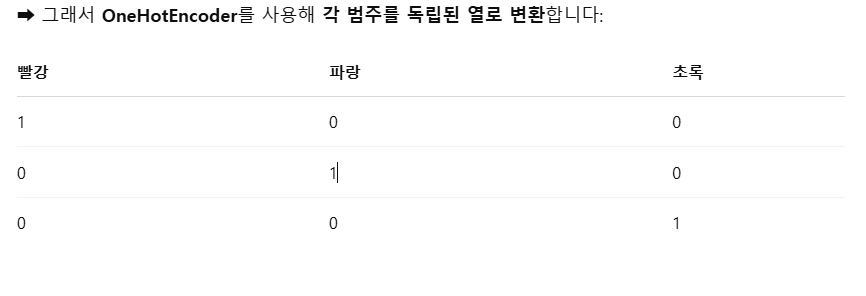


4-3. One-Hot Encoding categorical variables (Droped Data)

In [ ]:
cat_cols = X_train_drop.select_dtypes(include='object').columns
num_cols = X_train_drop.select_dtypes(exclude='object').columns

encoder_drop = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_drop.fit(X_train_drop[cat_cols]) # 훈련 데이터에만 fit

# 범주형 → 문자열을 수치로 인코딩해야 모델이 학습 가능
X_train_drop_cat = encoder_drop.transform(X_train_drop[cat_cols])
X_test_drop_cat = encoder_drop.transform(X_test_drop[cat_cols])  # 테스트는 transform만

# 숫자형 → 이미 숫자이므로 추가 변환 없이 배열로만 바꿔줌
X_train_drop_num = X_train_drop[num_cols].values # X_train_drop[num_cols] → 숫자형 컬럼들만 선택한 DataFrame
X_test_drop_num = X_test_drop[num_cols].values #.values → DataFrame을 NumPy 배열 (ndarray) 로 변환

X_train_drop_final = np.hstack([X_train_drop_num, X_train_drop_cat])
X_test_drop_final = np.hstack([X_test_drop_num, X_test_drop_cat])

print(f"Final feature shape - Train: {X_train_drop_final.shape}, Test: {X_test_drop_final.shape}")

Final feature shape - Train: (24148, 103), Test: (6014, 103)





---


🔹 `.columns`는 OneHotEncoder와 직접적으로 관계 있는 건 아니고,

🔹 DataFrame에서 범주형 컬럼만 선택할 때 사용하는 Pandas 코드


❓ .columns는 뭐 할때 사용하는가?
```
cat_cols = X_train_drop.select_dtypes(include='object').columns
```
* 여기서 .columns는 DataFrame에서 컬럼 이름만 뽑아내는 역할
* 그 DataFrame의 **컬럼 이름(index object)**만 반환 (Index([...]) 형태)



```
X_train_drop.select_dtypes(include='object')
```
* 범주형 컬럼들만 DataFrame으로 반환


결론적으로
```
encoder.fit(X_train_drop[cat_cols])
```
이렇게 쓰는 것이 일반적임.


---




4-3. One-Hot Encoding categorical variables (Imputed Data)

In [ ]:
cat_cols = X_train_cat_imp.columns
num_cols = X_train_num_imp.columns

encoder_imp = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_imp.fit(X_train_imp[cat_cols])

X_train_imp_cat = encoder_imp.transform(X_train_imp[cat_cols])
X_test_imp_cat = encoder_imp.transform(X_test_imp[cat_cols])

X_train_imp_num = X_train_imp[num_cols].values
X_test_imp_num = X_test_imp[num_cols].values


X_train_imp_final = np.hstack([X_train_imp_num, X_train_imp_cat])
X_test_imp_final = np.hstack([X_test_imp_num, X_test_imp_cat])
#오류: One-Hot Encoding 이후 열 개수가 왜 늘어나는지??

print(f"Final feature shape - Train: {X_train_imp_final.shape}, Test: {X_test_imp_final.shape}")

Final feature shape - Train: (26048, 104), Test: (6513, 104)


Scaling all features...

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_imp_final)
X_train_scaled = scaler.transform(X_train_imp_final)
X_test_scaled = scaler.transform(X_test_imp_final)

print("Scaling complete.")

Scaling complete.


#### 분류 모델 학습

4.4 Training Logistic Regression

>SVC는 SVM의 한 종류이며, 클래스 이름을 그대로 쓰는 것이 명확하고 혼란을 줄일 수 있음.

>따라서 일반적으로는 from sklearn.svm import SVC 그대로 사용함.

+) SVC는 분류기고, SVR은 회귀기 / SVM은 이 둘을 모두 포함하는 포괄 개념이라 혼동 우려 있음

In [ ]:
from sklearn.svm import SVC

# Drop 방식 - Logistic Regression
lr_drop_model = LogisticRegression(max_iter=1000)
lr_drop_model.fit(X_train_drop_final, y_train_drop)

# Drop 방식 - SVM (RBF kernel)
svm_drop_model = SVC(kernel='rbf')
svm_drop_model.fit(X_train_drop_final, y_train_drop)

# Impute 방식 - Logistic Regression
lr_imp_model = LogisticRegression(max_iter=1000)
lr_imp_model.fit(X_train_scaled, y_train_imp)

# Impute 방식 - SVM (RBF kernel)
svm_imp_model = SVC(kernel='rbf')
svm_imp_model.fit(X_train_scaled, y_train_imp)


print("Training complete.")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training complete.


#### 성능 평가 및 비교

4.5 Evaluating on test set

In [ ]:
# Drop 방식 - Logistic Regression
lr_drop_predict = lr_drop_model.predict(X_test_drop_final)

lr_drop_acc = accuracy_score(y_test_drop, lr_drop_predict)
print("\n[Drop 방식 - Logistic Regression 결과]")
print(f"Accuracy: {lr_drop_acc:.4f}")
print(classification_report(y_test_drop,lr_drop_predict))


svm_drop_predict = svm_drop_model.predict(X_test_drop_final)

svm_drop_acc = accuracy_score(y_test_drop, svm_drop_predict)
print("\n[Drop 방식 - SVM (RBF) 결과]")
print(f"Accuracy: {svm_drop_acc:.4f}")
print(classification_report(y_test_drop, svm_drop_predict))


lr_imp_predict = lr_imp_model.predict(X_test_scaled)

print("\n[Impute 방식 - Logistic Regression 결과]")
print("Accuracy:", accuracy_score(y_test, lr_imp_predict))
print(classification_report(y_test, lr_imp_predict))


svm_imp_predict = svm_imp_model.predict(X_test_scaled)

print("\n[Impute 방식 - SVM (RBF) 결과]")
print("Accuracy:", accuracy_score(y_test, svm_imp_predict))
print(classification_report(y_test, svm_imp_predict))


[Drop 방식 - Logistic Regression 결과]
Accuracy: 0.8395
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4510
           1       0.73      0.57      0.64      1504

    accuracy                           0.84      6014
   macro avg       0.80      0.75      0.77      6014
weighted avg       0.83      0.84      0.83      6014


[Drop 방식 - SVM (RBF) 결과]
Accuracy: 0.7850
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4510
           1       0.98      0.14      0.25      1504

    accuracy                           0.79      6014
   macro avg       0.88      0.57      0.56      6014
weighted avg       0.83      0.79      0.72      6014


[Impute 방식 - Logistic Regression 결과]
Accuracy: 0.8516812528788577
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.74      0.60      0.66      1568

    accuracy       